# Analysis on Drop Validation results
## Drop-trained model (v0)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import re
import os


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


t5_model = 't5-small'

In [2]:
#choose a version
local_versions = glob.glob('./data/*',recursive=True)
local_versions  = [x for x in local_versions if 'experiments' not in x]
print('versions available locally:')
for x in range(len(local_versions)):
    print(f'{x+1}. {local_versions[x]}')
selection = -1    
while(selection not in range(len(local_versions)+1)):
    selection = input('Enter number: ')
    try:
        selection = int(selection)
    except:
        print('please enter a number')

selection -= 1
version_dir = local_versions[selection]
    
data_dir = f"{version_dir}/{t5_model}"
results_dir = f"{data_dir}/results/"
assert os.path.exists(results_dir), 'error, no results found in folder {}'.format(results_dir)

#choose a results file
files = glob.glob(results_dir+'*.pkl',recursive=True)
for i in range(len(files)):
    print(f'{i+1}. {files[i].rsplit("/",1)[1]}')
selection = -1    
while(selection not in range(len(files)+1)):
    selection = input('Enter number: ')
    try:
        selection = int(selection)
    except:
        print('please enter a number')    
selection -= 1        

print('Importing dataframe of results...')
df = pd.read_pickle(files[selection])
print(f'F1 score: {df.F1.mean():0.5f}')
print(f'EM score: {df.EM.mean():0.5f}')
df.head()

versions available locally:
1. ./data/aug_small-v0
2. ./data/drop3-aug1-drop3-aug1-vAlpha
3. ./data/drop30-v0
4. ./data/squad-5epochs-v0
5. ./data/augmented-v0
6. ./data/drop-augmented-v0
7. ./data/squad-v0
8. ./data/drop5-aug5-v0
9. ./data/drop10-v0
10. ./data/drop-v0
11. ./data/drop3-aug1-vAlpha
12. ./data/augmented10-drop5-v0
13. ./data/drop-5epochs-squad-5epochs-v0
14. ./data/drop5-aug5-drop5-v0
15. ./data/squad-augmented-v0
16. ./data/augmented-data
17. ./data/squad-60epochs-v0
18. ./data/drop5-v0
19. ./data/drop3-aug1-drop3-vAlpha
20. ./data/drop3-vAlpha
21. ./data/drop-60epochs-v0


Enter number:  11


1. augmented_validation2227-Jul26.pkl
2. augmented_validation2215-Jul26.pkl


Enter number:  1


Importing dataframe of results...
F1 score: 0.37016
EM score: 0.32910


,section_id,query_id,passage,question,answers_spans,predicted,EM,F1
0,nfl_1184,f37e81fa-ef7b-4583-b671-762fc433faa9,Hoping to rebound from their loss to the Patr...,Who scored the first touchdown of the game?,"{'spans': ['Chaz Schilens', 'JaMarcus Russell'...",Chaz Schilens,1.0,1.0
1,nfl_1184,ac6ba235-3024-4f63-a6ab-730a14def4cb,Hoping to rebound from their loss to the Patr...,How many field goals did Kris Brown kick?,"{'spans': ['2', '3', '3', '3', '3'], 'types': ...",2,1.0,1.0
2,nfl_1184,2c7c93f6-69ed-47cc-a5af-94a00c185a26,Hoping to rebound from their loss to the Patr...,Which team won the game?,"{'spans': ['Raiders', 'Raiders', 'Raiders', 't...",Raiders,1.0,1.0
3,nfl_1184,7dfd2b64-f39e-4bb4-aeb0-1900adda6018,Hoping to rebound from their loss to the Patr...,How many field goals did both teams kick in th...,"{'spans': ['2', '2', '2', '2', '2'], 'types': ...",1,0.0,0.0
4,nfl_1184,121a8f57-7752-4373-a9ba-748b2c577cd2,Hoping to rebound from their loss to the Patr...,How many more yards was Kris Browns's first fi...,"{'spans': ['29', '20', '29', '29', '29'], 'typ...",10,0.0,0.0


In [3]:
def tag_questions(df):

    df.reset_index(drop=True, inplace = True) #clean up - adding indicies
    
    df['answer_type'] = df.answers_spans.apply(lambda d: d['types'][0])
#     print('answer type value counts: \n',df.answer_type.value_counts())

    df['answers_list'] = df.answers_spans.apply(lambda z: z['spans'])


    df['EasyQ'] = df.apply(lambda z: 1 if len(set(z['passage'].split()).intersection(set(z.answers_list))) > 0 else 0,axis=1)
    df['MathEasyQ'] = np.where((df.EasyQ == 1) &(df.answer_type == 'number'),1,0)
    df['MathHardQ'] = np.where((df.answer_type == 'number')&(df.MathEasyQ == 0),1,0)

    
#     #tag columns
#     question_labels = ['Or','Sort','Who','What','When','Where','How','Which','Boolean']
#     for label in question_labels:
#         df[label] = 0

    df['Or'] = np.where(df.question.str.contains(" or ", flags=re.IGNORECASE), 1, 0)
    
    sort_keywords = ["est ","first","last","more","less","better","worse","larger","smaller"]
    
    sort_pat = '|'.join(sort_keywords)
    df['Sort'] = np.where(df.question.str.contains(sort_pat,flags=re.IGNORECASE), 1, 0)

    for q in ['Who','What','When','Where','Why','How','Which']:
        df[q] = np.where(df.question.str.lower().str.contains(q.lower()),1,0)
    
    df['Boolean'] = np.where(df.question.str.startswith('Is'),1,0)
    df['Boolean'] = np.where(df.question.str.startswith('Was'),1,df.Boolean)
    df['Boolean'] = np.where(df.question.str.startswith('Did'),1,df.Boolean)
    df['Boolean'] = np.where(df.question.str.startswith('Were'),1,df.Boolean)
    
    q_list = ['Or','Sort','Who','What','When','Where','Why','How','Which','Boolean','MathEasyQ','MathHardQ']
    for q in q_list:
        print('question type: {}\n  * count: {:,}\n  * avg F1: {:0.5f}\n  * avg EM: {:0.5f}\n'.format(q,sum(df[q] == 1),df[df[q]==1].F1.mean(),df[df[q]==1].EM.mean()))
        
    df['check_tot'] = df[['Or','Sort','Who','What','When','Where','Why','How','Which','Boolean']].sum(axis=1)
    
    return df

df = tag_questions(df)

question type: Or
  * count: 1,805
  * avg F1: 0.61736
  * avg EM: 0.54571

question type: Sort
  * count: 3,971
  * avg F1: 0.41665
  * avg EM: 0.36867

question type: Who
  * count: 683
  * avg F1: 0.52890
  * avg EM: 0.47584

question type: What
  * count: 596
  * avg F1: 0.44948
  * avg EM: 0.30369

question type: When
  * count: 108
  * avg F1: 0.19222
  * avg EM: 0.12037

question type: Where
  * count: 87
  * avg F1: 0.47103
  * avg EM: 0.41379

question type: Why
  * count: 8
  * avg F1: 0.08375
  * avg EM: 0.00000

question type: How
  * count: 5,955
  * avg F1: 0.27053
  * avg EM: 0.26801

question type: Which
  * count: 1,989
  * avg F1: 0.55470
  * avg EM: 0.44394

question type: Boolean
  * count: 228
  * avg F1: 0.55105
  * avg EM: 0.47368

question type: MathEasyQ
  * count: 361
  * avg F1: 0.32424
  * avg EM: 0.31025

question type: MathHardQ
  * count: 5,528
  * avg F1: 0.27182
  * avg EM: 0.27008



In [4]:
df.answer_type.value_counts()

number    5889
span      3503
date       143
Name: answer_type, dtype: int64

In [14]:
df.head()

,section_id,query_id,passage,question,answers_spans,predicted,EM,F1,answer_type,answers_list,EasyQ,MathEasyQ,MathHardQ,Or,Sort,Who,What,When,Where,Why,How,Which,Boolean,check_tot
0,nfl_1184,f37e81fa-ef7b-4583-b671-762fc433faa9,Hoping to rebound from their loss to the Patr...,Who scored the first touchdown of the game?,"{'spans': ['Chaz Schilens', 'JaMarcus Russell'...",Chaz Schilens,1.0,1.0,span,"[Chaz Schilens, JaMarcus Russell]",0,0,0,0,1,1,0,0,0,0,0,0,0,2
1,nfl_1184,ac6ba235-3024-4f63-a6ab-730a14def4cb,Hoping to rebound from their loss to the Patr...,How many field goals did Kris Brown kick?,"{'spans': ['2', '3', '3', '3', '3'], 'types': ...",2,1.0,1.0,number,"[2, 3, 3, 3, 3]",0,0,1,0,0,0,0,0,0,0,1,0,0,1
2,nfl_1184,2c7c93f6-69ed-47cc-a5af-94a00c185a26,Hoping to rebound from their loss to the Patr...,Which team won the game?,"{'spans': ['Raiders', 'Raiders', 'Raiders', 't...",Raiders,1.0,1.0,span,"[Raiders, Raiders, Raiders, the Raiders, the R...",1,0,0,0,0,0,0,0,0,0,0,1,0,1
3,nfl_1184,7dfd2b64-f39e-4bb4-aeb0-1900adda6018,Hoping to rebound from their loss to the Patr...,How many field goals did both teams kick in th...,"{'spans': ['2', '2', '2', '2', '2'], 'types': ...",1,0.0,0.0,number,"[2, 2, 2, 2, 2]",0,0,1,0,1,0,0,0,0,0,1,0,0,2
4,nfl_1184,121a8f57-7752-4373-a9ba-748b2c577cd2,Hoping to rebound from their loss to the Patr...,How many more yards was Kris Browns's first fi...,"{'spans': ['29', '20', '29', '29', '29'], 'typ...",10,0.0,0.0,number,"[29, 20, 29, 29, 29]",0,0,1,0,1,0,0,0,0,0,1,0,0,2


/home/omar/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='answer_type', ylabel='count'>

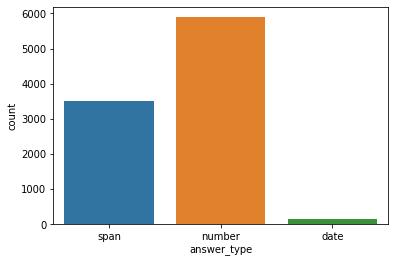

In [13]:
sns.countplot(df.answer_type)

In [20]:
query_id = '6f1888c9-e249-4b44-ab85-78a309a36880'
print_example(query_id,df)

question:  How many yards of field goals did Gould kick?
passage:   Trying to snap a six-game losing skid, the Lions returned home for an NFC North rematch the-now 2-time NFC North champion Chicago Bears.  In the first quarter, the Bears struck first with kicker Robbie Gould nailing a 36-yard field goal.  Afterwards, the Lions took the lead with QB Jon Kitna completing a 23-yard TD pass to TE Dan Campbell.  In the second quarter, Chicago bounced back with QB Rex Grossman completing a 13-yard TD pass to WR Bernard Berrian.  Afterwards, RB Adrian Peterson got a 2-yard TD run.  In the third quarter, Detroit retook the lead with Kitna completing a 20-yard TD pass to WR Mike Furrey and a 2-yard TD pass to WR Roy Williams.  However, in the fourth quarter, the inconsistency that continues to plague the Lions showed as the Bears won with Gould getting a 36-yard field goal, a 39-yard field goal, and a 44-yard field goal and on a dropped pass by Mike Williams in the endzone on the last play of t

In [18]:
df[(df.answer_type == 'number')&(df.predicted.str.contains(' '))].head()

,section_id,query_id,passage,question,answers_spans,predicted,EM,F1,answer_type,answers_list,EasyQ,MathEasyQ,MathHardQ,Or,Sort,Who,What,When,Where,Why,How,Which,Boolean,check_tot
23,nfl_995,405ab3fb-9392-4a23-9589-8c9c5d9b9508,"Still searching for their first win, the Beng...",What was the longest TD pass of the game?,"{'spans': ['57', '57'], 'types': ['number', 'n...",57 -yard,0.0,0.67,number,"[57, 57]",0,0,1,0,1,0,1,0,0,0,0,0,0,2
83,nfl_153,6f1888c9-e249-4b44-ab85-78a309a36880,"Trying to snap a six-game losing skid, the Li...",How many yards of field goals did Gould kick?,"{'spans': ['4', '155'], 'types': ['number', 'n...",11 1,0.0,0.00,number,"[4, 155]",0,0,1,0,0,0,0,0,0,0,1,0,0,1
88,history_1708,b05a1937-c080-41e4-81a4-d2b0b2087965,"In 1905, 1,003 Korean immigrants, which includ...",How many more Korean immigrant men were there ...,"{'spans': ['571', '571'], 'types': ['number', ...",10 0,0.0,0.00,number,"[571, 571]",0,0,1,0,1,0,0,0,0,0,1,0,0,2
89,history_1708,2b959aed-f25f-4b71-88e4-7bbcb999fd49,"In 1905, 1,003 Korean immigrants, which includ...",How many Korean immigrants were more men than ...,"{'spans': ['571', '571'], 'types': ['number', ...",10 0,0.0,0.00,number,"[571, 571]",0,0,1,0,1,0,0,0,0,0,1,0,0,2
93,history_1708,a20c5d22-4168-420b-8b4e-d634cdb3b468,"In 1905, 1,003 Korean immigrants, which includ...",How many more men were there than women and ch...,"{'spans': ['571', '571'], 'types': ['number', ...",10 0,0.0,0.00,number,"[571, 571]",0,0,1,0,1,1,0,0,0,0,1,0,0,3


In [16]:
df[df.answer_type == 'date'].head()

,section_id,query_id,passage,question,answers_spans,predicted,EM,F1,answer_type,answers_list,EasyQ,MathEasyQ,MathHardQ,Or,Sort,Who,What,When,Where,Why,How,Which,Boolean,check_tot
69,history_655,95b02abd-70ba-4aa6-b215-1a83d63cfd8b,"In 1085, Guadalajara was retaken by the Christ...",When did the first battle against Guadalajara ...,"{'spans': ['1085'], 'types': ['date']}",12 12,0.0,0.0,date,[1085],1,0,0,0,1,0,0,1,0,0,0,0,0,2
106,history_2044,4ef57f34-8c7c-4500-bc1f-2d2512e35523,The first issue in 1942 consisted of denominat...,"What year were the replacement notes of the 1,...","{'spans': ['1943', '1943', '1943', '1943'], 't...",19 44,0.0,0.0,date,"[1943, 1943, 1943, 1943]",0,0,0,0,0,0,1,0,0,0,0,0,0,1
107,history_2044,44524b32-f04f-435f-94d5-53cb38ccbe2b,The first issue in 1942 consisted of denominat...,Was the largest peso note printed in 1944 or 1...,"{'spans': ['1945', '1945', '1945'], 'types': [...",19 45,0.0,0.0,date,"[1945, 1945, 1945]",0,0,0,1,1,0,0,0,0,0,0,0,1,3
109,history_2044,0903294b-08fc-4061-937a-44890a55ca78,The first issue in 1942 consisted of denominat...,In which year were there replacement notes of ...,"{'spans': ['1943', '1943', '1943'], 'types': [...",19 44,0.0,0.0,date,"[1943, 1943, 1943]",0,0,0,0,0,0,0,0,0,0,0,1,0,1
113,history_2044,6a77cfec-7ab9-4a3a-9752-9a56324c1e32,The first issue in 1942 consisted of denominat...,"Which year ushered in the largest Pesos note, ...","{'spans': ['1945', '1945', '1945'], 'types': [...",19 44,0.0,0.0,date,"[1945, 1945, 1945]",0,0,0,1,1,0,0,0,0,0,0,1,0,3


In [15]:
df.head()

,section_id,query_id,passage,question,answers_spans,predicted,EM,F1,answer_type,answers_list,EasyQ,MathEasyQ,MathHardQ,Or,Sort,Who,What,When,Where,Why,How,Which,Boolean,check_tot
0,nfl_1184,f37e81fa-ef7b-4583-b671-762fc433faa9,Hoping to rebound from their loss to the Patr...,Who scored the first touchdown of the game?,"{'spans': ['Chaz Schilens', 'JaMarcus Russell'...",Vonta Leach,0.0,0.0,span,"[Chaz Schilens, JaMarcus Russell]",0,0,0,0,1,1,0,0,0,0,0,0,0,2
1,nfl_1184,ac6ba235-3024-4f63-a6ab-730a14def4cb,Hoping to rebound from their loss to the Patr...,How many field goals did Kris Brown kick?,"{'spans': ['2', '3', '3', '3', '3'], 'types': ...",3,1.0,1.0,number,"[2, 3, 3, 3, 3]",0,0,1,0,0,0,0,0,0,0,1,0,0,1
2,nfl_1184,2c7c93f6-69ed-47cc-a5af-94a00c185a26,Hoping to rebound from their loss to the Patr...,Which team won the game?,"{'spans': ['Raiders', 'Raiders', 'Raiders', 't...",Houston Texans,0.0,0.0,span,"[Raiders, Raiders, Raiders, the Raiders, the R...",1,0,0,0,0,0,0,0,0,0,0,1,0,1
3,nfl_1184,7dfd2b64-f39e-4bb4-aeb0-1900adda6018,Hoping to rebound from their loss to the Patr...,How many field goals did both teams kick in th...,"{'spans': ['2', '2', '2', '2', '2'], 'types': ...",2,1.0,1.0,number,"[2, 2, 2, 2, 2]",0,0,1,0,1,0,0,0,0,0,1,0,0,2
4,nfl_1184,121a8f57-7752-4373-a9ba-748b2c577cd2,Hoping to rebound from their loss to the Patr...,How many more yards was Kris Browns's first fi...,"{'spans': ['29', '20', '29', '29', '29'], 'typ...",1,0.0,0.0,number,"[29, 20, 29, 29, 29]",0,0,1,0,1,0,0,0,0,0,1,0,0,2


In [ ]:
def tag_questions_2(df):

    df.reset_index(drop=True, inplace = True) #clean up - adding indicies
    
    df['answer_type'] = df.answers_spans.apply(lambda d: d['types'][0])
#     print('answer type value counts: \n',df.answer_type.value_counts())

    df['answers_list'] = df.answers_spans.apply(lambda z: z['spans'])


    df['EasyQ'] = df.apply(lambda z: 1 if len(set(z['passage'].split()).intersection(set(z.answers_list))) > 0 else 0,axis=1)
    df['MathEasyQ'] = np.where((df.EasyQ == 1) &(df.answer_type == 'number'),1,0)
    df['MathHardQ'] = np.where((df.answer_type == 'number')&(df.MathEasyQ == 0),1,0)
    df['qtype'] = ''
    df['qtype'] = np.where(df.MathEasyQ == 1,df.qtype + 'MathEasy-',df.qtype)
    df['qtype'] = np.where(df.MathHardQ == 1,df.qtype + 'MathHard-',df.qtype)
    
#     #tag columns
#     question_labels = ['Or','Sort','Who','What','When','Where','How','Which','Boolean']
#     for label in question_labels:
#         df[label] = 0
    
    df['Or'] = np.where(df.question.str.contains(" or ", flags=re.IGNORECASE), 1, df.Or)
    
    sort_keywords = ["est ","first","last","more","less","better","worse","larger","smaller"]
    
    sort_pat = '|'.join(sort_keywords)
    df['Sort'] = np.where(df.question.str.contains(sort_pat,flags=re.IGNORECASE), 1, df.Sort)
    df['qypte'] = np.where(df.Sort == 1, df.qtype + 'Sort-',df.qtype)
    
    
    for q in ['Who','What','When','Where','Why','How','Which']:
        df[q] = np.where(df.question.str.lower().str.contains(q.lower()),1,0)
        df['qypte'] = np.where(df[q] == 1, df.qtype + '{}-'.format(q),df.qtype)
    
    df['Boolean'] = np.where(df.question.str.startswith('Is'),1,0)
    df['Boolean'] = np.where(df.question.str.startswith('Was'),1,df.Boolean)
    df['Boolean'] = np.where(df.question.str.startswith('Did'),1,df.Boolean)
    df['Boolean'] = np.where(df.question.str.startswith('Were'),1,df.Boolean)
    
    df['qtype'] = np.where(df.Boolean == 1, df.qtype+'Boolean-',df.qtype)
    
    q_list = ['Or','Sort','Who','What','When','Where','Why','How','Which','Boolean','MathEasyQ','MathHardQ']
    for q in q_list:
        print('question type: {}\n  * count: {:,}\n  * avg F1: {:0.5f}\n  * avg EM: {:0.5f}\n'.format(q,sum(df[q] == 1),df[df[q]==1].F1.mean(),df[df[q]==1].EM.mean()))
        
    df['check_tot'] = df[['Or','Sort','Who','What','When','Where','Why','How','Which','Boolean']].sum(axis=1)
    
    return df

df = tag_questions_2(df)

In [ ]:
df.qtype.value_counts()

In [ ]:
df.head()

In [5]:
def print_example(query_id,df):
    print('question: ',df.loc[df.query_id == query_id,'question'].iloc[0])
    print('passage: ',df.loc[df.query_id == query_id,'passage'].iloc[0])
    print('\npredicted answer: ',df.loc[df.query_id == query_id,'predicted'].iloc[0])
    print('True answers: ',df.loc[df.query_id == query_id,'answers_spans'].iloc[0])
    print('F1 score: ',df.loc[df.query_id == query_id,'F1'].iloc[0])
    print('EM score: ',df.loc[df.query_id == query_id,'EM'].iloc[0])
    
    
query_id = '0686d1f9-4a8e-4031-b665-49d425afb777'
print_example(query_id,df)

question:  What kind of people were on the ships that arrived at St. Croix in August?
passage:  Danish officials appealed for help to French colonists at Martinique, located 324 miles away. Two French ships arrived from there to St. John on April 23, 1734, carrying several hundred French and Swiss troops to try to take control from the rebels. With their firepower and troops, by mid-May they had restored planters' rule of the island. The French ships returned to Martinique on June 1, leaving the local militia to track down the remaining rebels, which they did over the next three months. The slave insurrection was considered ended on August 25, 1734 when Sergeant Øttingen captured the remaining maroon rebels. The loss of life and property from the insurrection caused many St. John landowners to move to St. Croix, a nearby island bought by the Danish from the French in 1733. Four ships carried planters and their families from Charlotte Amalie in August. While they found St. Croix to be a

In [6]:
query_id = '86dd1721-6bf4-45fa-b01e-de47e4f7301d'
print_example(query_id,df)

question:  How many percent are not Marriage couples living together?
passage:  There were 664,594 households out of which 24.35% had children under the age of 18 living with them, 46.28% were Marriage living together, 11.68% had a female householder with no husband present, and 37.40% were non-families. 30.11% of all households were made up of individuals and 14.70% (4.02% male and 10.68% female) had someone living alone who was 65 years of age or older. The average household size was 2.39 and the average family size was 2.97.

predicted answer:  53.72
True answers:  {'spans': array(['53.72', '46.28', '53.72', '37.4'], dtype=object), 'types': array(['number', 'number', 'number', 'number'], dtype=object)}
F1 score:  1.0
EM score:  1.0


In [7]:
query_id = 'ad19857f-cd76-4d01-ba29-1a589cfee053'
print_example(query_id,df)

question:  How many rushing touchdowns occurred in the game?
passage:   The Eagles faced off with the Baltimore Ravens in an interconference matchup.  Both defenses dominated the first quarter, and in the second quarter, Baltimore forced three turnovers (two interceptions and a fumble) from Donovan McNabb.  Ravens kicker Matt Stover booted a 44-yard field goal, while quarterback Joe Flacco completed a 1-yard touchdown pass to tight end Daniel Wilcox.  However, rookie  Quintin Demps returned the following kickoff 100 yards for a Philadelphia touchdown to make it 10-7 Ravens at halftime.  Andy Reid decided to bench McNabb (who was 8-for-18 for 59 yards and two interceptions) and put backup quarterback Kevin Kolb into the game.  Kolb also struggled with the Baltimore defense, and the Eagles fell behind 12-7 when linebacker Jameel McClain blocked Sav Rocca's punt into the back of the endzone for a safety. In the fourth, the Ravens kicked another field goal after a Kolb interception, then M

In [8]:
df.head()

,section_id,query_id,passage,question,answers_spans,predicted,EM,F1,answer_type,answers_list,EasyQ,MathEasyQ,MathHardQ,Or,Sort,Who,What,When,Where,Why,How,Which,Boolean,check_tot
0,nfl_1184,f37e81fa-ef7b-4583-b671-762fc433faa9,Hoping to rebound from their loss to the Patr...,Who scored the first touchdown of the game?,"{'spans': ['Chaz Schilens', 'JaMarcus Russell'...",Chaz Schilens,1.0,1.0,span,"[Chaz Schilens, JaMarcus Russell]",0,0,0,0,1,1,0,0,0,0,0,0,0,2
1,nfl_1184,ac6ba235-3024-4f63-a6ab-730a14def4cb,Hoping to rebound from their loss to the Patr...,How many field goals did Kris Brown kick?,"{'spans': ['2', '3', '3', '3', '3'], 'types': ...",2,1.0,1.0,number,"[2, 3, 3, 3, 3]",0,0,1,0,0,0,0,0,0,0,1,0,0,1
2,nfl_1184,2c7c93f6-69ed-47cc-a5af-94a00c185a26,Hoping to rebound from their loss to the Patr...,Which team won the game?,"{'spans': ['Raiders', 'Raiders', 'Raiders', 't...",Raiders,1.0,1.0,span,"[Raiders, Raiders, Raiders, the Raiders, the R...",1,0,0,0,0,0,0,0,0,0,0,1,0,1
3,nfl_1184,7dfd2b64-f39e-4bb4-aeb0-1900adda6018,Hoping to rebound from their loss to the Patr...,How many field goals did both teams kick in th...,"{'spans': ['2', '2', '2', '2', '2'], 'types': ...",1,0.0,0.0,number,"[2, 2, 2, 2, 2]",0,0,1,0,1,0,0,0,0,0,1,0,0,2
4,nfl_1184,121a8f57-7752-4373-a9ba-748b2c577cd2,Hoping to rebound from their loss to the Patr...,How many more yards was Kris Browns's first fi...,"{'spans': ['29', '20', '29', '29', '29'], 'typ...",10,0.0,0.0,number,"[29, 20, 29, 29, 29]",0,0,1,0,1,0,0,0,0,0,1,0,0,2


In [9]:
print_example('c78fec38-c81b-4775-a760-ad9cb32f4817',df)

question:  How long did the Sack of Brescia last?
passage:  The Sack of Brescia took place on February 18, 1512 during the War of the League of Cambrai. The city of Brescia had revolted against French control, garrisoning itself with Venetian troops. Gaston de Foix, recently arrived to command the French armies in Italy, ordered the city to surrender; when it refused, he attacked it with around 12,000 men. The French attack took place in a pouring rain, through a field of mud; Foix ordered his men to remove their shoes for better traction. The defenders inflicted heavy casualties on the French, but were eventually overrun, suffering 8,000 - 15,000 casualties. The Gascon infantry and landsknechts then proceeded to thoroughly sack the city, massacring thousands of civilians over the next five days. Following this, the city of Bergamo paid some 60,000 ducats to the French to avoid a similar fate.

predicted answer:  60,000
True answers:  {'spans': array(['5', 'five days', 'five days'], dt

In [10]:
print_example('1f6b2aa8-fd2b-4de2-99ad-6c5fdc4cd267',df)

question:  How many hours was Fox Sports 1 down this year compared to last year?
passage:  The 2018 edition of the U.S. Open featured a total of 37 hours of coverage in the United States, with 19.5 hours being on Thursday and Friday, and 17.5 hours being on Saturday and Sunday; the Fox Sports 1 cable network carried a total of 13.5 hours of coverage on Thursday and Friday. The Fox broadcast network had a total of 23.5 hours of coverage Thursday through Sunday, with 6 hours Thursday and Friday, and 17.5 hours Saturday and Sunday. The overall 37-hour total was down 1.5 hours from last years total of 38.5 hours, due to the Fox broadcast networks coverage having 23.5 hours this year, compared to the 24.5 hours it had last year, and the Fox Sports 1 cable networks 13.5 hours this year, compared to the 14 hours it had last year.

predicted answer:  10.5
True answers:  {'spans': array(['1.5', '.5'], dtype=object), 'types': array(['number', 'number'], dtype=object)}
F1 score:  0.0
EM score:  0

In [11]:
print_example('29648c25-d6fb-4ab3-a8ed-c38e3e493968',df)

question:  How many fewer Soviet prisoners of war were in the official totals than in the Finish estmates?
passage:  According to Finnish historians, the casualties of the Finnish Defence Forces amounted to 63,204 dead or missing and around 158,000 wounded. Officially, the Soviets captured 2,377 Finnish prisoners of war in the Soviet Union, although Finnish researchers estimated the number to be around 3,500 prisoners. 939 Finnish civilians died in air raids and 190 civilians were killed by Soviet partisans. Germany suffered approximately 84,000 casualties in the Finnish front, 16,400 killed, 60,400 wounded and 6,800 missing. In addition to the original peace terms of restoring the 1940 border, Finland was required to Finnish war reparations to the Soviet Union, conduct War-responsibility trials in Finland, lease Porkkalanniemi to the Soviets as well as ban fascist elements and allow left-wing groups, such as the Communist Party of Finland. A Soviet-led Allied Control Commission was in

In [12]:
print_example('dc25acdd-3478-445f-becd-ce26caaca231',df)

question:  How many people in total would occupy 6 square miles of this county based on the population density in the census of 2000?
passage:  As of the census of 2000, there were 445,342 people, 169,162 households, and 114,015 families residing in the county.  The population density was 615 people per square mile (238/km²).  There were 178,913 housing units at an average density of 247 per square mile (95/km²).  The racial makeup of the county was 82.19% Race (United States Census), 1.15% Race (United States Census) or Race (United States Census), 0.65% Race (United States Census), 6.68% Race (United States Census), 0.30% Race (United States Census), 5.86% from Race (United States Census), and 3.17% from two or more races.  11.17% of the population were Race (United States Census) or Race (United States Census) of any race. 17.2% were of German American, 9.9% English American, 8.2% Irish American, and 6.7% Americans ancestry. 81.7% spoke only English at home, while 9.6% spoke Spanish

In [ ]:
df[df.MathHardQ == 1].head()

In [ ]:
print_example('f37e81fa-ef7b-4583-b671-762fc433faa9',df)

In [ ]:
df[['EasyQ','MathEasyQ','MathHardQ']].describe()

In [ ]:
df.MathEasy.describe()

In [ ]:
df[df.answers_list.isin(df.question)].head()

In [ ]:
df.head()

In [ ]:
q_list = ['Or','Sort','Who','What','When','Where','Why','How','Which','Boolean','MathEasyQ','MathHardQ']
all_count = []
all_F1 = []
all_EM = []

for q in q_list:
    count = sum(df[q] == 1)
    F1 = df[df[q]==1].F1.mean()
    EM = df[df[q]==1].EM.mean()
    all_count.append(count)
    all_F1.append(F1)
    all_EM.append(EM)
    


In [ ]:
fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(15,5))

ax[0] = sns.barplot(x=q_list,y=all_count,ax=ax[0])
_=ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=90)
_=ax[0].set_title('Counts of Question Types')

ax[1] = sns.barplot(x=q_list,y=all_F1,ax=ax[1])
_=ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=90)
_=ax[1].set_title('Question Type F1 values')

ax[2] = sns.barplot(x=q_list,y=all_EM,ax=ax[2])
_=ax[2].set_xticklabels(ax[2].get_xticklabels(),rotation=90)
_=ax[2].set_title('Question Type EM values')

In [ ]:
df.head()

In [ ]:
df.check_tot.value_counts()

In [ ]:
print_example('95717e8a-3e01-44ac-9ad8-ebdc8746f3c0',df)

In [ ]:
q_list = ['Or','Sort','Who','What','When','Where','Why','How','Which','Boolean','MathEasyQ','MathHardQ']
all_count = []
all_F1 = []
all_EM = []

for q in q_list:
    count = sum(df[q] == 1)
    F1 = df[df[q]==1].F1.mean()
    EM = df[df[q]==1].EM.mean()
    all_count.append(count)
    all_F1.append(F1)
    all_EM.append(EM)
    


In [ ]:
nrows = 2
ncols = 5
counter = 0
qTypes = ['Or','Sort','Who','What','When','Where','Why','How','Which','Boolean']

fig,ax = plt.subplots(nrows=nrows,ncols=ncols,sharey=True,figsize=(25,10))
for row in range(nrows):
    for col in range(ncols):
        ax[row,col] = sns.histplot(data=df[df[qTypes[counter]]==1],x='F1',label=qTypes[counter],ax=ax[row,col])
        ax[row,col].set_title(f'{qTypes[counter]}, Avg F1: {df[df[qTypes[counter]] == 1].F1.mean():0.5f}')
        counter += 1
    

In [ ]:
q_list = ['Or','Who','What','When','Where','How','Which','Boolean','MathEasyQ','MathHardQ']
for q in q_list:
    print('question type: {} + Sort\n  * count: {:,}\n  * avg F1: {:0.5f}\n  * avg EM: {:0.5f}\n'.format(q,sum((df[q] == 1)&(df.Sort == 1)),df[(df[q] == 1)&(df.Sort == 1)].F1.mean(),df[(df[q] == 1)&(df.Sort == 1)].EM.mean()))

In [ ]:
sns.histplot(data=df,x='F1')

In [ ]:
df.head()

In [ ]:
sum((df.MathHardQ == 1)&(df.Sort == 1))

In [ ]:
df[(df.MathHardQ == 1)&(df.Sort == 1)].sample()

In [ ]:

print_example('bcf578c2-0271-4f54-b980-cb438b34df2d',df)

In [10]:
#really tough MATH & SORT question!!
print_example('c94cef85-f269-43cf-8279-14892239dedf',df)
print('\n------------------------\n')
#another tough MATH SORT
print_example('e2514a1c-07d1-49dc-b987-0dd832b5bd52',df)

question:  How many points did the Ravens score in their two highest scoring games combined?
passage:  Baltimore managed to beat the Jets 10-9 on the 2010 opener, but then lost a poorly-played game against Cincinnati the following week. The Ravens rebounded against the other two division teams, beating Cleveland 24-17 in Week 3 and then Pittsburgh 17-14 in Week 4. The Ravens scored a fine win (31-17) at home against Denver in Week 5. After an overtime loss to New England, they narrowly avoided losing at home to the winless Bills. Next, the Ravens hosted Miami and won 26-10, breaking that teams 4-0 road streak. On Thursday Night, the team headed to Atlanta and lost 26-21 in a game that had some criticizing the officiating. The Ravens finished the season 12-4, second in the division due to a tiebreaker with Pittsburgh, and earning a wild card spot. Baltimore headed to Kansas City and crushed the unprepared Chiefs 30-7, but once again were knocked from the playoffs by Pittsburgh in a hard

In [ ]:
df.check_tot.value_counts()

In [ ]:
df[df.check_tot == 0].head()

In [ ]:
print_example('ac6ba235-3024-4f63-a6ab-730a14def4cb',df)

In [ ]:
df[df.check_tot == 3].head()

In [ ]:
print_example('f6fc8e67-5aa2-4a04-b65e-05a154bcc1ae',df)

In [ ]:
pd.set_options

In [ ]:
df.loc[df.query_id == 'e08a599f-39cc-4d28-8092-1ccaf367247d',:]

In [ ]:
q_list = ['Or','Sort','Who','What','When','Where','Why','How','Which','Boolean']
for q in q_list:
    print('question: ',q,'  count: {}\n'.format(sum(df[q] == 1)))

In [ ]:
df[df.Sort == 1].sample(4)

In [ ]:
qTypes = ['Or','Sort','Who','What','When','Where','Why','How','Which','Boolean'] #,'Math'
df[qTypes].sum()

In [ ]:
for qtype in qTypes:
    print(f'Question type: {qtype}')
    print(f'* Number of questions: {len(df[df[qtype] == 1])}')
    print(f'* Average F1 score: {df[df[qtype] == 1].F1.mean():0.5f}')
    print(f'* Average EM score: {df[df[qtype] == 1].EM.mean():0.5f}\n')

In [ ]:
df[df.How == 1].sample(5)

In [ ]:
df[df.How == 1].sample(5)

In [ ]:
print_example('29b34c2b-89ad-4697-bdfc-5cee4e64830e',df)

In [ ]:
print_example('f01bc2c5-d683-44cb-988d-b6aed9bdb049',df)

In [ ]:
print_example('bb96ca91-0c34-420d-85d3-ef723e8b8853',df)

In [ ]:
df[df.When == 1].head()

In [ ]:
df.loc[69,'predicted']

In [ ]:
df.loc[69,'answers_spans']

In [ ]:
df.loc[69,'passage']

In [ ]:
df.loc[69,'question']

In [ ]:
nrows = 2
ncols = 5
counter = 0
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(25,10))
for row in range(nrows):
    for col in range(ncols):
        ax[row,col] = sns.histplot(data=df[df[qTypes[counter]]==1],x='F1',label=qTypes[counter],ax=ax[row,col])
        ax[row,col].set_title(f'{qTypes[counter]}, Avg F1: {df[df[qTypes[counter]] == 1].F1.mean():0.5f}')
        counter += 1
    